In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.2 MB/s eta 0:00:00


LOGISTIC REGRESSION MODEL FOR PATIENT RISK PREDICTION
Dataset Shape: (200020, 17)
Number of features: 16

1. DATA QUALITY CHECK:
----------------------------------------
✓ No missing values found

✓ Target encoding:
  High Risk -> 0
  Low Risk -> 1

2. CLASS DISTRIBUTION:
----------------------------------------
Risk Category
High Risk    105115
Low Risk      94905
Name: count, dtype: int64

Class Balance:
  High Risk: 105115 samples (52.6%)
  Low Risk: 94905 samples (47.4%)

3. DATA SPLIT:
----------------------------------------
Training set: 160016 samples
Test set: 40004 samples
Number of features: 10

4. FEATURE SCALING:
----------------------------------------
✓ StandardScaler applied to numerical features

5. TRAINING LOGISTIC REGRESSION MODEL:
----------------------------------------

Training Logistic Regression (Default)...
  ✓ Training completed
  Test Accuracy: 0.8165
  F1-Score: 0.8082
  ROC-AUC: 0.8984

Training Logistic Regression (L1 Regularization)...
  ✓ Training comp

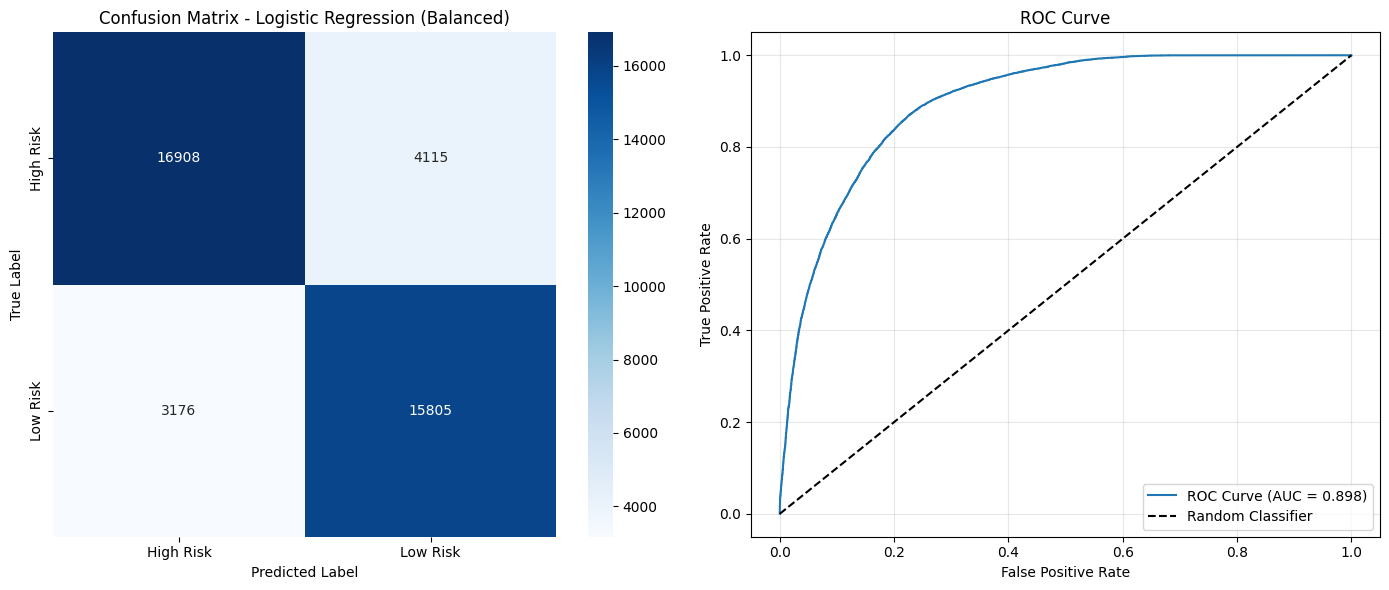


8. FEATURE COEFFICIENTS:
----------------------------------------
Interpretation: Positive coefficients increase High Risk probability
Negative coefficients decrease High Risk probability

                 Feature  Coefficient
             Derived_BMI   -17.145715
             Weight (kg)    12.483109
              Height (m)   -10.391080
              Heart Rate    -1.367114
                  Gender     0.019008
 Systolic Blood Pressure     0.009392
       Oxygen Saturation     0.008958
Diastolic Blood Pressure    -0.004744
        Body Temperature    -0.001264
                     Age     0.001114


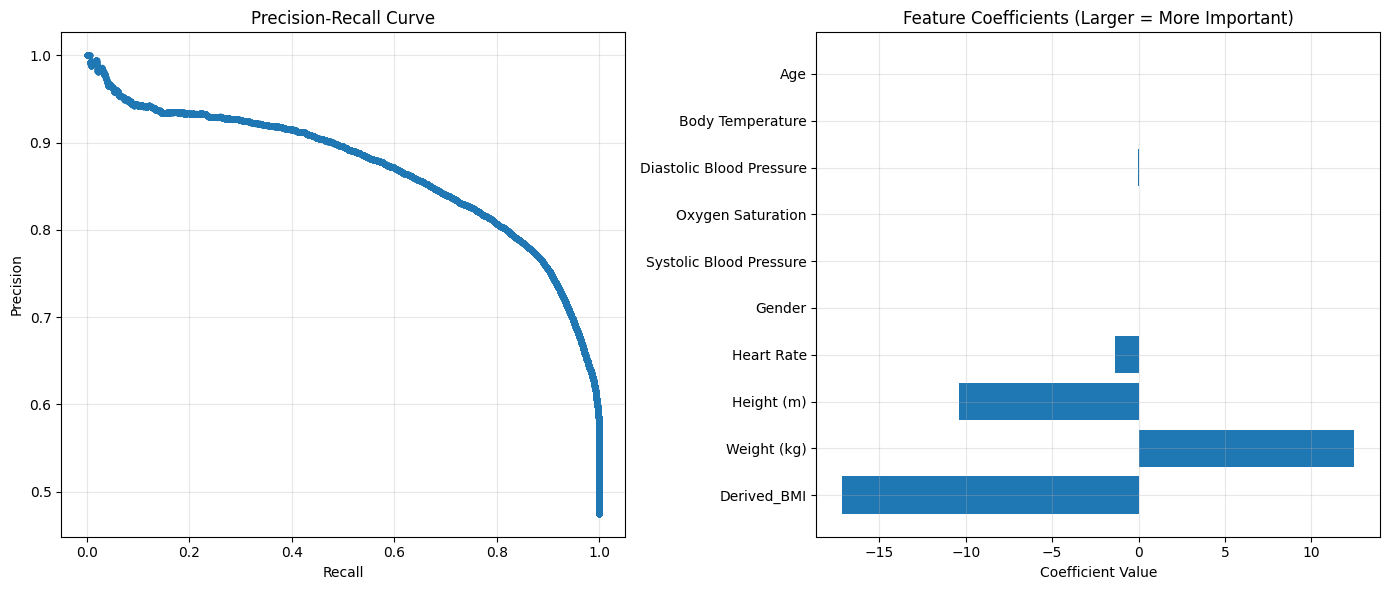


9. MODEL INTERPRETATION:
----------------------------------------
Top 3 features increasing High Risk probability:
  Weight (kg): +12.4831
  Gender: +0.0190
  Systolic Blood Pressure: +0.0094

Top 3 features decreasing High Risk probability:
  Derived_BMI: -17.1457
  Height (m): -10.3911
  Heart Rate: -1.3671

Model Intercept: -0.4431
(Base log-odds when all features are at their mean)

10. EXAMPLE PREDICTIONS:
----------------------------------------

Patient 1 Prediction:
  Risk Category: Low Risk
  Probability - Low Risk: 0.119
  Probability - High Risk: 0.881
  Confidence: 88.1%

Patient 2 Prediction:
  Risk Category: High Risk
  Probability - Low Risk: 0.886
  Probability - High Risk: 0.114
  Confidence: 88.6%

11. MODEL SAVED:
----------------------------------------
✓ Model saved to 'logistic_regression_model/' directory
  Files saved:
  - best_logistic_model.pkl (trained model)
  - scaler.pkl (feature scaler)
  - label_encoder.pkl (target encoder)
  - features.txt (feature nam

In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, precision_recall_curve,
                           ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset
df = pd.read_csv('human_vital_signs_dataset_2024.csv')


print(f"Dataset Shape: {df.shape}")
print(f"Number of features: {len(df.columns) - 1}")  # Excluding target

# Data Preprocessing


# Select features and target from our data
features = ['Heart Rate', 'Body Temperature', 'Oxygen Saturation',
            'Systolic Blood Pressure', 'Diastolic Blood Pressure',
            'Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Derived_BMI']
target = 'Risk Category'

# Check for missing values
print("\n1. DATA QUALITY CHECK:")

missing_values = df[features + [target]].isnull().sum()
if missing_values.sum() == 0:
    print("No missing values found")
else:
    print("Missing values found:")
    print(missing_values[missing_values > 0])

# Convert Gender to numeric column
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# Encode target variable
label_encoder = LabelEncoder()
df['Risk_Encoded'] = label_encoder.fit_transform(df[target])
print(f"\n Target encoding:")
for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {original} -> {encoded}")

# Checking class distribution
print("\n CLASS DISTRIBUTION:")

class_dist = df[target].value_counts()
print(class_dist)
print(f"\n Class Balance:")
for risk_class, count in class_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {risk_class}: {count} samples ({percentage:.1f}%)")

# Prepare data
X = df[features]
y = df['Risk_Encoded']

# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n DATA SPLIT:")

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

# Scaling numerical features
scaler = StandardScaler()
numerical_features = ['Heart Rate', 'Body Temperature', 'Oxygen Saturation',
                      'Systolic Blood Pressure', 'Diastolic Blood Pressure',
                      'Age', 'Weight (kg)', 'Height (m)', 'Derived_BMI']

print("\n FEATURE SCALING:")
print(" StandardScaler applied to numerical features")

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# Train Logistic Regression model
print("\n TRAINING LOGISTIC REGRESSION MODEL:")


# Initialize Logistic Regression with different configurations to test
log_reg_models = {
    #Lasso
    'Logistic Regression (Default)': LogisticRegression(random_state=42, max_iter=1000),
    'Logistic Regression (L1 Regularization)': LogisticRegression(
        penalty='l1',
        solver='liblinear',
        random_state=42,
        max_iter=1000,
        C=1.0
    ),
    # Ridge
    'Logistic Regression (L2 Regularization)': LogisticRegression(
        penalty='l2',
        random_state=42,
        max_iter=1000,
        C=1.0
    ),
    'Logistic Regression (Balanced)': LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    )
}

# Dictionary to store results
results = {}

# Train and evaluate each Logistic Regression configuration
for model_name, model in log_reg_models.items():
    print(f"\nTraining {model_name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba_test)

    # Store results
    results[model_name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'y_pred_test': y_pred_test,
        'y_pred_proba_test': y_pred_proba_test,
        'coefficients': model.coef_[0] if hasattr(model, 'coef_') else None,
        'intercept': model.intercept_[0] if hasattr(model, 'intercept_') else None
    }

    print(f"  Training completed")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

# Compare all Logistic Regression configurations
print("\n MODEL COMPARISON:")


comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name,
        'Train Acc': f"{metrics['train_accuracy']:.4f}",
        'Test Acc': f"{metrics['test_accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1_score']:.4f}",
        'ROC-AUC': f"{metrics['roc_auc']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Comparison of Logistic Regression Models:")
print(comparison_df.to_string(index=False))

# Select the best model based on test accuracy
best_model_name = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
best_model = results[best_model_name]['model']
print(f"\n✓ Best Model: {best_model_name}")

# Detailed evaluation of the best model
print("\n DETAILED EVALUATION OF BEST MODEL:")

print(f"Model: {best_model_name}")

# Get predictions from best model
y_pred_best = results[best_model_name]['y_pred_test']
y_pred_proba_best = results[best_model_name]['y_pred_proba_test']

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best,
                          target_names=label_encoder.classes_))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
print(cm)

# Visualize the confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[0])
axes[0].set_title(f'Confusion Matrix - {best_model_name}')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
axes[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {results[best_model_name]["roc_auc"]:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba_best)
axes[0].plot(recall_vals, precision_vals, marker='.')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].grid(True, alpha=0.3)

# Prediction function for new patients
def predict_patient_risk(patient_data, model=best_model, scaler=scaler,
                        label_encoder=label_encoder, features_list=features)
    # Create DataFrame from input
    patient_df = pd.DataFrame([patient_data])

    # Convert Gender if present
    if 'Gender' in patient_df.columns:
        patient_df['Gender'] = patient_df['Gender'].map({'Male': 1, 'Female': 0})

    # Ensure all features are present
    for feature in features_list:
        if feature not in patient_df.columns:
            patient_df[feature] = 0

    # Scale numerical features
    patient_scaled = patient_df.copy()
    patient_scaled[numerical_features] = scaler.transform(patient_df[numerical_features])

    # Make prediction
    prediction = model.predict(patient_scaled[features_list])
    probability = model.predict_proba(patient_scaled[features_list])[0]

    risk_label = label_encoder.inverse_transform(prediction)[0]

    return {
        'risk_category': risk_label,
        'probability_low_risk': probability[0],
        'probability_high_risk': probability[1],
        'prediction_confidence': max(probability)
    }

# Example predictions
print("\n10. EXAMPLE PREDICTIONS:")
print("-" * 40)

# Example 1: Typical patient
patient1 = {
    'Heart Rate': 72,
    'Body Temperature': 36.8,
    'Oxygen Saturation': 97.5,
    'Systolic Blood Pressure': 125,
    'Diastolic Blood Pressure': 80,
    'Age': 35,
    'Gender': 'Female',
    'Weight (kg)': 65.0,
    'Height (m)': 1.65,
    'Derived_BMI': 23.88
}

# Example 2: High-risk patient
patient2 = {
    'Heart Rate': 95,
    'Body Temperature': 37.5,
    'Oxygen Saturation': 92.0,
    'Systolic Blood Pressure': 150,
    'Diastolic Blood Pressure': 95,
    'Age': 65,
    'Gender': 'Male',
    'Weight (kg)': 90.0,
    'Height (m)': 1.70,
    'Derived_BMI': 31.14
}

# Make predictions
for i, patient in enumerate([patient1, patient2], 1):
    result = predict_patient_risk(patient)
    print(f"\nPatient {i} Prediction:")
    print(f"  Risk Category: {result['risk_category']}")
    print(f"  Probability - Low Risk: {result['probability_low_risk']:.3f}")
    print(f"  Probability - High Risk: {result['probability_high_risk']:.3f}")
    print(f"  Confidence: {result['prediction_confidence']:.1%}")

# Save the best model
import joblib
import os

# Create directory for models
os.makedirs('logistic_regression_model', exist_ok=True)

# Save model components
joblib.dump(best_model, 'logistic_regression_model/best_logistic_model.pkl')
joblib.dump(scaler, 'logistic_regression_model/scaler.pkl')
joblib.dump(label_encoder, 'logistic_regression_model/label_encoder.pkl')

# Save feature names
with open('logistic_regression_model/features.txt', 'w') as f:
    for feature in features:
        f.write(f"{feature}\n")

print("\n MODEL SAVED:")

print(" Model saved to 'logistic_regression_model/' directory")
print("  Files saved:")
print("  - best_logistic_model.pkl (trained model)")
print("  - scaler.pkl (feature scaler)")
print("  - label_encoder.pkl (target encoder)")
print("  - features.txt (feature names)")

# Summary statistics
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"Dataset: {len(df)} patients")
print(f"Features used: {len(features)}")
print(f"Best model: {best_model_name}")
print(f"Test accuracy: {results[best_model_name]['test_accuracy']:.2%}")
print(f"ROC-AUC score: {results[best_model_name]['roc_auc']:.3f}")
print(f"F1-Score: {results[best_model_name]['f1_score']:.3f}")
print("\nModel is ready for deployment!")
